# Fundamental set up

## Import util

In [0]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Drive Mount

In [0]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

## Tensorboard setup

In [0]:
%load_ext tensorboard

In [0]:
import torch
ROOT_LOG_DIR = "/content/drive/My Drive/UPenn_Class/CIS 522/FinalProject/Spiking-Neural-Network-SNN-with-PyTorch-where-Backpropagation-engenders-STDP/logs"
# ROOT_LOG_DIR = "/content"

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_DIR = "test" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, TENSORBOARD_DIR))

In [0]:
DATA_NAME_LOSS = "Loss"
DATA_NAME_ACC = "Acuracy"

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

<IPython.core.display.Javascript object>

# Data Loading

In [0]:
!git clone https://github.com/hsjeong5/MNIST-for-Numpy.git

Cloning into 'MNIST-for-Numpy'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47
Unpacking objects: 100% (47/47), done.


## Load data for non deep learning method

In [0]:
from MNIST_for_Numpy import mnist
# genenrate train test set
mnist.init()
x_train, t_train, x_test, t_test = mnist.load()
x_train = x_train/255.0
x_test = x_test/255.0

# Split validation set and training set
X_train, X_val, y_train, y_val = train_test_split(x_train, t_train, test_size = 0.2, random_state = 1)

Download complete.
Save complete.


## Load data for deep learning method

In [0]:
def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

def download_cifar(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    # transformation = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.CIFAR10(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.CIFAR10(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

In [0]:
batch_size = 64
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader_mnist = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader_mnist = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
batch_size = 64
DATA_PATH = './data'

training_set, testing_set = download_cifar(DATA_PATH)
train_set_loader_cifar10 = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader_cifar10 = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model initialization

## PAC

In [0]:
# classify with PAC
clf_pac = OneVsRestClassifier(PassiveAggressiveClassifier(random_state=0, tol=1e-3, max_iter=1000))

## CNN

In [0]:
class CNN(nn.Module):
    
    def __init__(self, HW=28, in_channels=1):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(int(HW/4)*int(HW/4)*32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

## Feed forward SNN

In [0]:
class SpikingNeuronLayer(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayer, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):

        if self.prev_inner.dim() == 1:

            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])

        input_excitation = self.fc(x)

        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        outer_excitation = F.relu(inner_excitation - self.threshold)

        do_penalize_gate = (outer_excitation > 0).float()

        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate

        outer_excitation = outer_excitation

        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output


class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1) 
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):

        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayer(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayer(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):

        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)

            layer1_state, layer1_output = self.layer1(xi)

            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):

        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

## Feed Forward SNN with Attention

In [0]:
class OutputDataToSpikingByAttn(nn.Module):

  def __init__(self, hidden_size):
    super(OutputDataToSpikingByAttn, self).__init__()
    self.fc = nn.Linear(hidden_size, 1)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, var):
    var2 = [i.unsqueeze(0) for i in var]
    var3 = torch.cat(var2)
    var4 = var3.transpose(0,1)
    var5 = self.fc(var4)

    attn = self.softmax(var5.squeeze(2)).unsqueeze(2)
    var6 = var3.transpose(0,1).transpose(1,2)
    output = torch.bmm(var6, attn).squeeze(2)

    return output

In [0]:
#@title
class SpikingNetWithAttn(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNetWithAttn, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayer(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayer(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=True)  
        self.attn_output = OutputDataToSpikingByAttn(10)
        
        self.to(self.device)
    
    def forward_through_time(self, x):

        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
          
            layer1_state, layer1_output = self.layer1(xi)

            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)

        out = self.attn_output(out[self.begin_eval:])

        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):

        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

## SCNN and SCNN-Res

In [0]:
class SNN_ResNetModule(nn.Module):
    '''
    For each module, the input and output H,W won't change.
    '''
    def __init__(self, device, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, padding_mode='zeros', use_shortcut=True,
                 decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        '''
        use_shortcut (bool): if ture, this module will act as a SNN_Resnet module; if false, this will act as a SCNN module
        '''
        super(SNN_ResNetModule, self).__init__()
        self.device = device

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.bias = bias
        self.padding_mode = padding_mode
        self.use_shortcut = use_shortcut

        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.conv2d = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, stride=self.stride, padding=self.padding,
                      dilation=self.dilation, bias=self.bias, padding_mode=self.padding_mode),
            nn.BatchNorm2d(self.out_channels),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(self.out_channels),
        )
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.out_channels]).to(self.device)
        self.prev_outer = torch.zeros([self.out_channels]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            batch_size = x.shape[0]
            H = x.shape[2]
            W = x.shape[3]
            self.prev_inner = torch.stack(batch_size * [torch.zeros([self.out_channels, H, W]).to(self.device)])
            self.prev_outer = torch.stack(batch_size * [torch.zeros([self.out_channels, H, W]).to(self.device)])
        
        # From net to spiking neuron
        if self.use_shortcut:
            if self.in_channels != self.out_channels:
                input_excitation = self.conv2d(x)+self.shortcut(x)
            else:  # same channels
                input_excitation = self.conv2d(x)+x
        else:  # no resnet, just conv2d
            input_excitation = self.conv2d(x)
        
        # Decay along time to construct spike
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # Post-synapse
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # Gate flag for neuron firing (pre-synapse)
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        outer_excitation = outer_excitation
        
        # Output
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output

In [0]:
class InputDataToSpikingPerceptronLayer_CNN(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer_CNN, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        # x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class OutputDataToSpikingPerceptronLayer_CNN(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer_CNN, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


class SpikingNet_CNN_Resnet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval, ch_in=1, HW=28, num_class=10, use_res=True):
        super(SpikingNet_CNN_Resnet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval

        self.ch_in = ch_in
        self.num_class = num_class
        self.use_res = use_res
        
        self.input_conversion = InputDataToSpikingPerceptronLayer_CNN(device)

        self.layer_conv1 = SNN_ResNetModule(device, self.ch_in, 16, 3, padding=1, use_shortcut=self.use_res, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5)
        # self.layer_conv2 = nn.Sequential(
        #     SNN_ResNetModule(8, 16, 5, padding=2, use_shortcut=False, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5),
        #     nn.MaxPool2d(2, stride=2),
        # )
        self.layer_conv2 = SNN_ResNetModule(device, 16, 32, 3, padding=1, use_shortcut=self.use_res, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5)
        self.layer_conv3 = SNN_ResNetModule(device, 32, 32, 3, padding=1, use_shortcut=self.use_res, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5)

        self.maxpool = nn.MaxPool2d(2, stride=2).to(device)
        
        self.layer1 = SpikingNeuronLayer(
            device, n_inputs=int((HW/4)*(HW/4)*32), n_hidden=256,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        self.layer2 = SpikingNeuronLayer(
            device, n_inputs=256, n_hidden=self.num_class,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer_conv1.reset_state()
        self.layer_conv2.reset_state()
        self.layer_conv3.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            X = self.input_conversion(x)

            # conv layer
            # xi = self.maxpool(self.layer_conv1(xi))
            # xi = self.maxpool(self.layer_conv2(xi))
            # xi = self.layer_conv3(xi)

            X_state1, X_output1 = self.layer_conv1(X)
            X_output1 = self.maxpool(X_output1)
            X_state2, X_output2 = self.layer_conv2(X_output1)
            X_output2 = self.maxpool(X_output2)
            X_state3, X_output3 = self.layer_conv3(X_output2)
            # X_state3, X_output3 = self.layer_conv3(X_output3)
            # X_state3, X_output3 = self.layer_conv3(X_output3)

            xi = X_output3.view(X_output3.size(0), -1)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

class CNN(nn.Module):
    
    def __init__(self, HW=28, in_channels=1):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(int(HW/4)*int(HW/4)*32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

# Train and test Model

## PAC trained on Mnist

In [0]:
# Train and test model 
clf_pac.fit(X_val, y_val)
clf_pac.score(x_test, t_test)

0.8793

In [0]:
# Do grid search to tune parameters
"""
Chosen Parameters:
  PassiveAggressiveClassifier: C=0.1, penalty=hinge

"""

# Define score
score = metrics.make_scorer(metrics.accuracy_score, needs_proba=False)

# Define classifier
clf = pipeline.Pipeline([('pac', clf_pac)])
print(clf.get_params().keys())

# define param grid
param_grid = {'pac__estimator__C': np.linspace(0.01,0.3,10),
        'pac__estimator__loss': ['hinge', 'squared_hinge']}

# Initialize Grid Search
search_result = []

# Re-split dataset into train and test(80/20)
X_train, X_val, y_train, y_val = train_test_split(x_train, t_train, test_size = 0.2, random_state = 1)
model = model_selection.GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score,
                verbose=10, cv=5)

# Fit model
model.fit(X_val, y_val)

print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

search_result.append(model.cv_results_)

dict_keys(['memory', 'steps', 'verbose', 'pac', 'pac__estimator__C', 'pac__estimator__average', 'pac__estimator__class_weight', 'pac__estimator__early_stopping', 'pac__estimator__fit_intercept', 'pac__estimator__loss', 'pac__estimator__max_iter', 'pac__estimator__n_iter_no_change', 'pac__estimator__n_jobs', 'pac__estimator__random_state', 'pac__estimator__shuffle', 'pac__estimator__tol', 'pac__estimator__validation_fraction', 'pac__estimator__verbose', 'pac__estimator__warm_start', 'pac__estimator', 'pac__n_jobs'])
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] pac__estimator__C=0.01, pac__estimator__loss=hinge ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  pac__estimator__C=0.01, pac__estimator__loss=hinge, score=0.896, total=   4.4s
[CV] pac__estimator__C=0.01, pac__estimator__loss=hinge ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=hinge, score=0.879, total=   4.8s
[CV] pac__estimator__C=0.01, pac__estimator__loss=hinge ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=hinge, score=0.905, total=   4.8s
[CV] pac__estimator__C=0.01, pac__estimator__loss=hinge ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.0s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=hinge, score=0.892, total=   4.9s
[CV] pac__estimator__C=0.01, pac__estimator__loss=hinge ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.9s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=hinge, score=0.898, total=   4.9s
[CV] pac__estimator__C=0.01, pac__estimator__loss=squared_hinge ......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.8s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=squared_hinge, score=0.890, total=   5.2s
[CV] pac__estimator__C=0.01, pac__estimator__loss=squared_hinge ......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.0s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=squared_hinge, score=0.876, total=   5.6s
[CV] pac__estimator__C=0.01, pac__estimator__loss=squared_hinge ......


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   34.6s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=squared_hinge, score=0.895, total=   5.4s
[CV] pac__estimator__C=0.01, pac__estimator__loss=squared_hinge ......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   40.0s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=squared_hinge, score=0.878, total=   5.1s
[CV] pac__estimator__C=0.01, pac__estimator__loss=squared_hinge ......


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   45.2s remaining:    0.0s


[CV]  pac__estimator__C=0.01, pac__estimator__loss=squared_hinge, score=0.876, total=   5.7s
[CV] pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge 
[CV]  pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge, score=0.892, total=   5.4s
[CV] pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge 
[CV]  pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge, score=0.860, total=   4.9s
[CV] pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge 
[CV]  pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge, score=0.889, total=   4.9s
[CV] pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge 
[CV]  pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge, score=0.874, total=   5.3s
[CV] pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge 
[CV]  pac__estimator__C=0.042222222222222223, pac__estimator__loss=hinge, score=0.878, total=   5.1s
[CV] pac__estimator__C=0.042222222222

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.2min finished


Best score: 0.894
Best parameters set:
	pac__estimator__C: 0.01
	pac__estimator__loss: 'hinge'


In [0]:
model.cv_results_

In [0]:
# train the model with best parameter
clf_pac = OneVsRestClassifier(PassiveAggressiveClassifier(C=0.01, loss='hinge', random_state=0, tol=1e-3, max_iter=1000))
clf_pac.fit(x_train, t_train)
clf_pac.score(x_test, t_test)

0.9158

##Feed Forward ANN and SNN

In [0]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):

    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
def train_many_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
            
def test(model, device, test_set_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item() 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")

###Train Feed Forward ANN

In [0]:
feed_forward_ann_model = NonSpikingNet().to(device)
train_many_epochs(feed_forward_ann_model)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.314690 Accuracy: 9.20%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.983513 Accuracy: 55.30%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.378106 Accuracy: 74.10%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.881172 Accuracy: 81.50%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.701104 Accuracy: 84.10%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.596527 Accuracy: 82.80%
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

Test set: Average loss: 0.0005, Accuracy: 8654/10000 (86.54%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.507252 Accuracy: 86.40%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.554603 Accuracy: 85.80%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.476428 Accuracy: 88.00%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.473180 Accuracy: 87.40%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.454935 Accuracy: 87.80%
Train E

### Train Feed Forward SNN

In [0]:
feed_forward_spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
train_many_epochs(feed_forward_spiking_model)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.539342 Accuracy: 12.90%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.888301 Accuracy: 24.00%
Train Epoch: 1 [20000/60000 (33%)] Loss: 2.097989 Accuracy: 38.90%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.737034 Accuracy: 76.20%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.666607 Accuracy: 80.80%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.437835 Accuracy: 88.20%
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

Test set: Average loss: 0.0005, Accuracy: 8418/10000 (84.18%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.542659 Accuracy: 82.60%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.376127 Accuracy: 89.70%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.448942 Accuracy: 87.00%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.411035 Accuracy: 89.50%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.398906 Accuracy: 88.50%
Train 

###Train Feed Forward SNN with Attention

In [0]:
feed_forward_spiking_model_attn = SpikingNetWithAttn(device, n_time_steps=128, begin_eval=0)
train_many_epochs(feed_forward_spiking_model_attn)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.473656 Accuracy: 10.80%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.765040 Accuracy: 40.10%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.952036 Accuracy: 47.70%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.664444 Accuracy: 78.60%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.494068 Accuracy: 85.20%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.475545 Accuracy: 85.90%
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

Test set: Average loss: 0.0004, Accuracy: 8588/10000 (85.88%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.457477 Accuracy: 84.50%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.462932 Accuracy: 85.30%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.387788 Accuracy: 88.30%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.374556 Accuracy: 89.00%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.385034 Accuracy: 87.70%
Train 

In [0]:
def pred(model, device, test_set_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    true = []
    predict = []
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            true.append(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item() 
            pred = output.max(1, keepdim=True)[1] 
            predict.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return true, predict


In [0]:
class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

In [0]:
def train_many_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
            
def test(model, device, test_set_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item() 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")


non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.305724 Accuracy: 9.70%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.853158 Accuracy: 66.80%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.243176 Accuracy: 76.60%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.851010 Accuracy: 81.40%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.664493 Accuracy: 84.90%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.577346 Accuracy: 84.50%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0005, Accuracy: 8746/10000 (87.46%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.554017 Accuracy: 85.70%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.540235 Accuracy: 85.40%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.483489 Accuracy: 87.30%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.479827 Accuracy: 88.70%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.430671 Accuracy: 87.80%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.457200 Accuracy: 88.10%

Test set: Average loss: 0.0004, Accuracy: 8906/10000 (89.06%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.434431 Accuracy: 88.40%
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.461692 Accuracy: 87.90%
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.421374 Accuracy: 89.70%
Train Epoch: 3 [30000/60000 (50%)] Loss: 0.433591 Accuracy: 88.00%
Train Epoch: 3 [40000/60000 (67%)] Loss: 0.406621 Accuracy: 89.90%
Train Epoch: 3 [50000/60000 (83%)] Loss: 0.411612 Accuracy: 89.40%

Test set: Average loss: 0.0004, Accuracy: 8916/10000 (89.16%)



###Spike Output Visualization

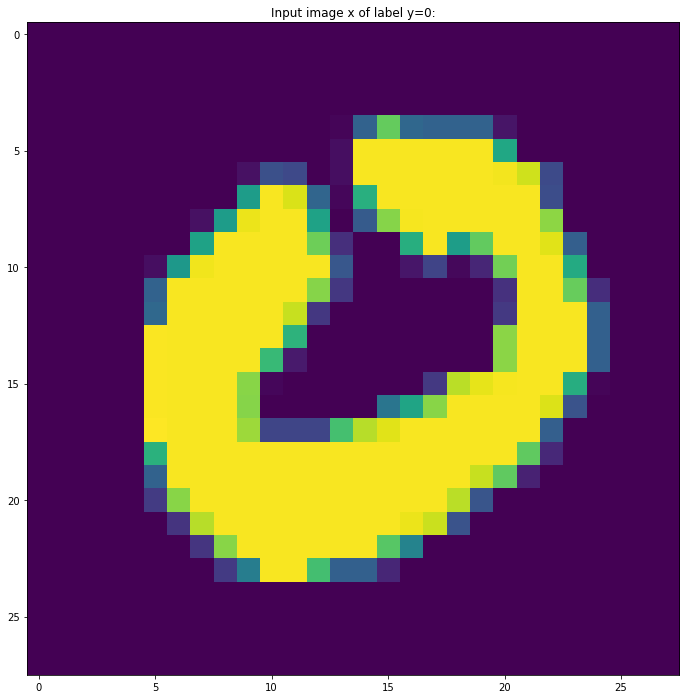

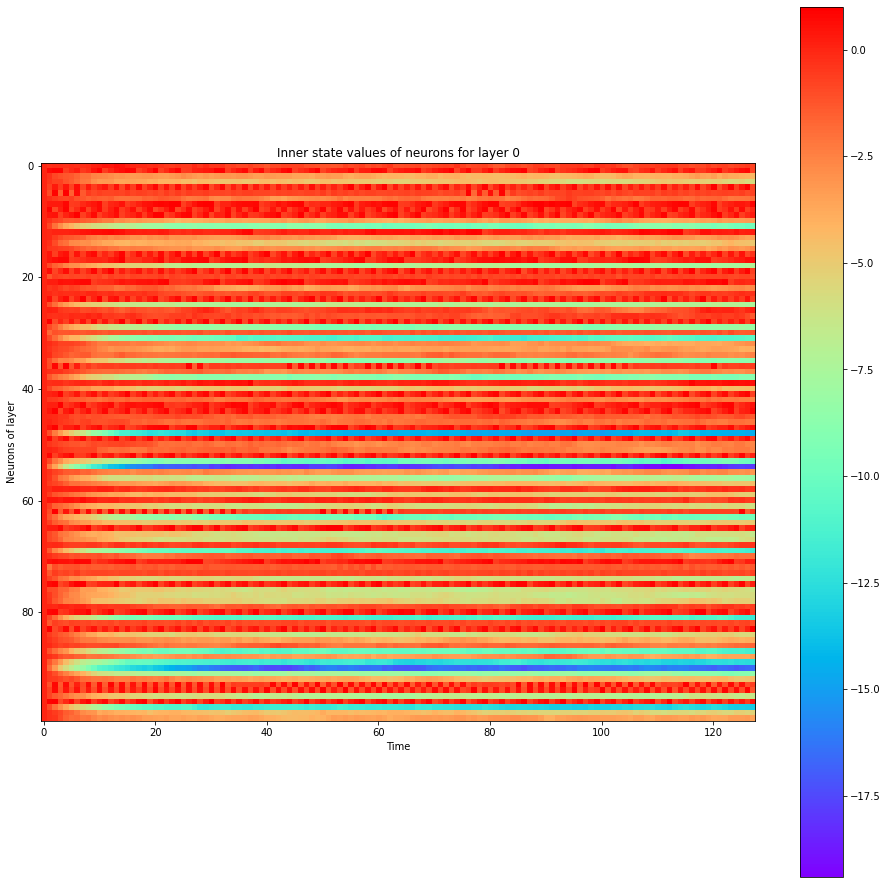

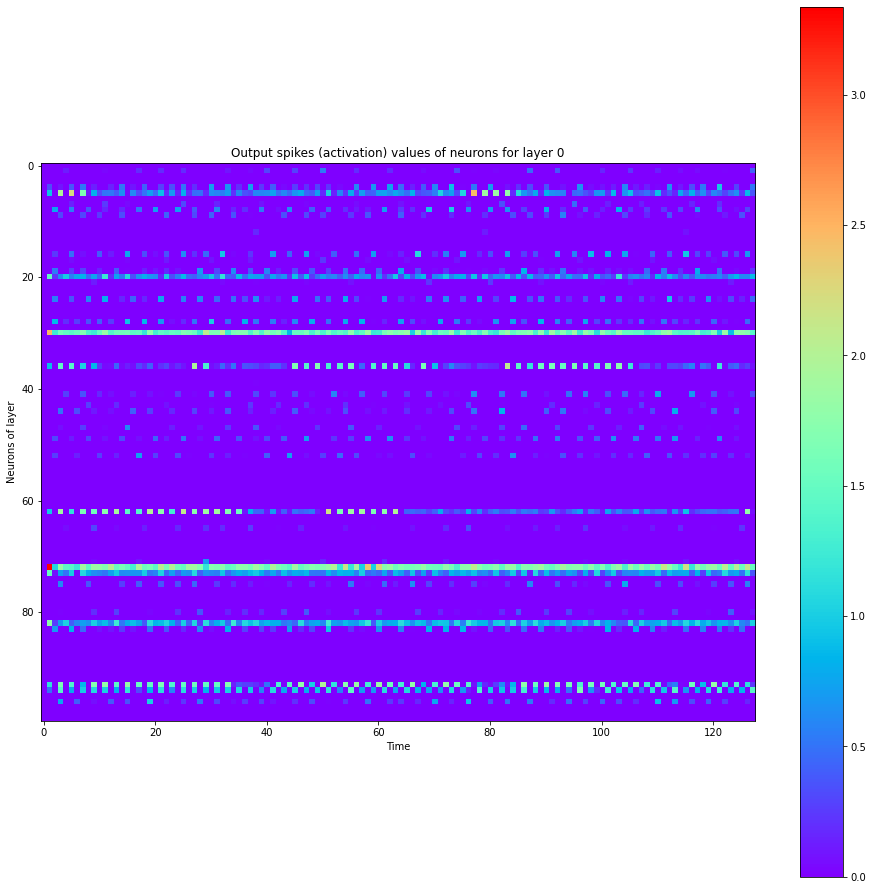

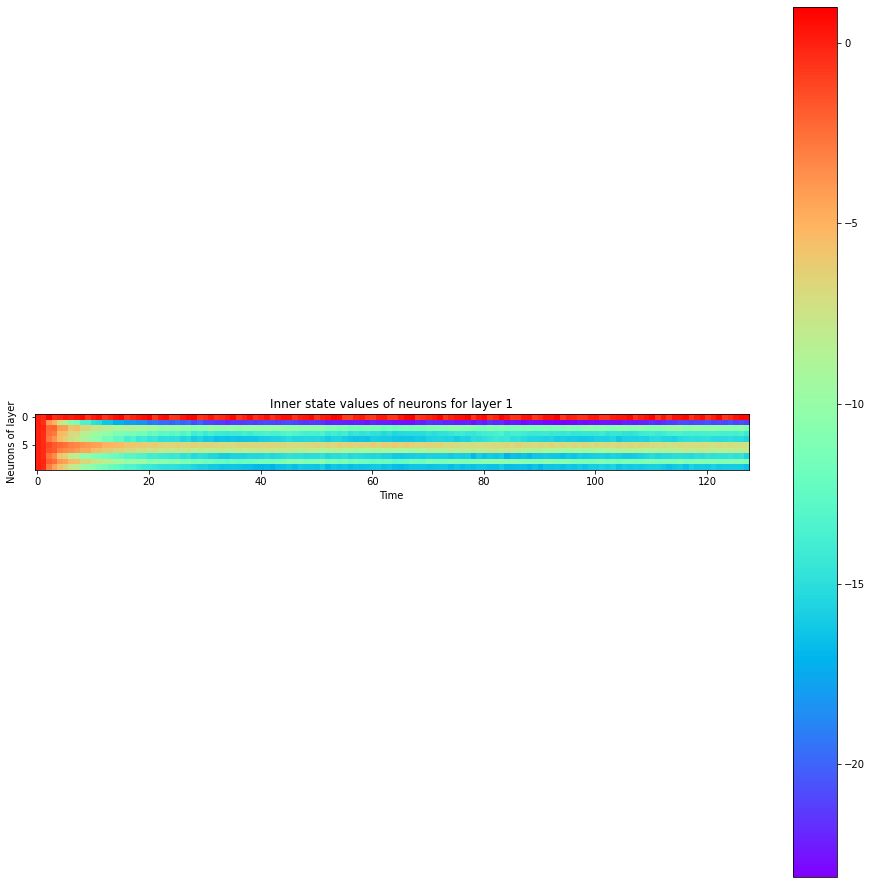

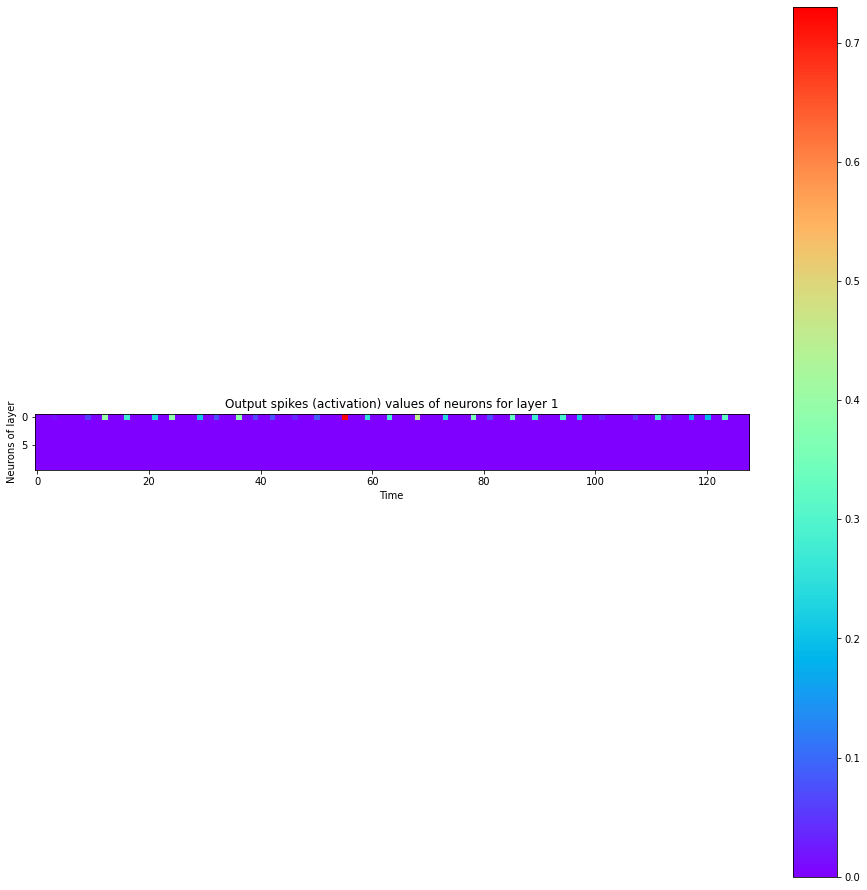

A hidden neuron that looks excited:


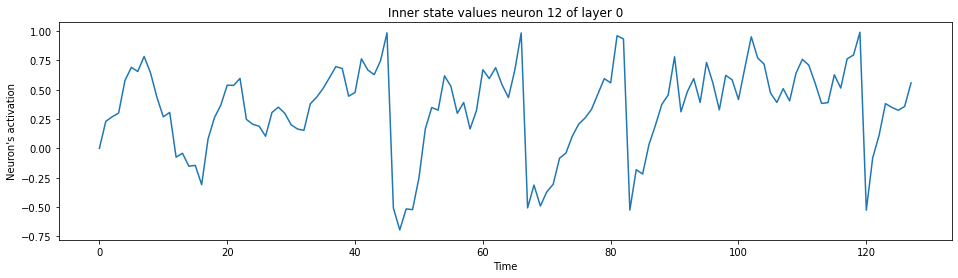

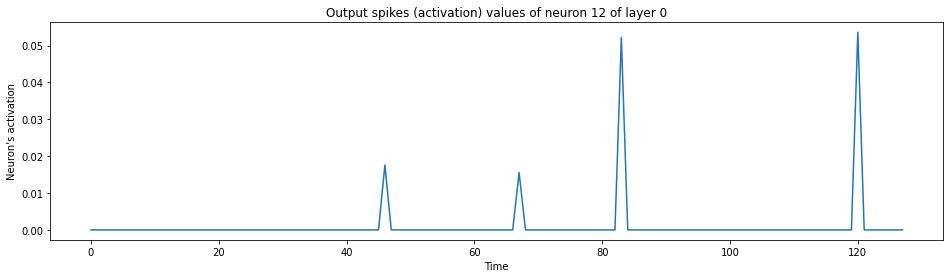

The output neuron of the label:


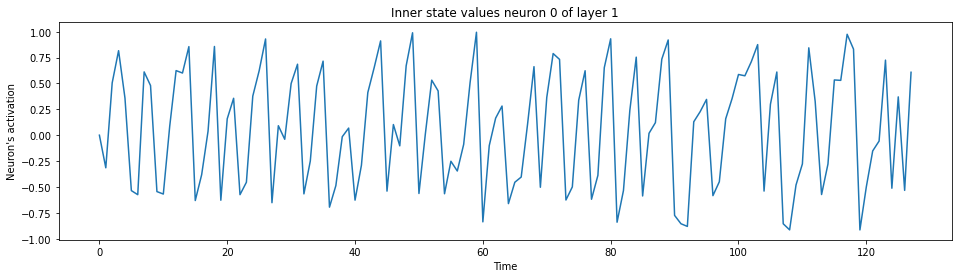

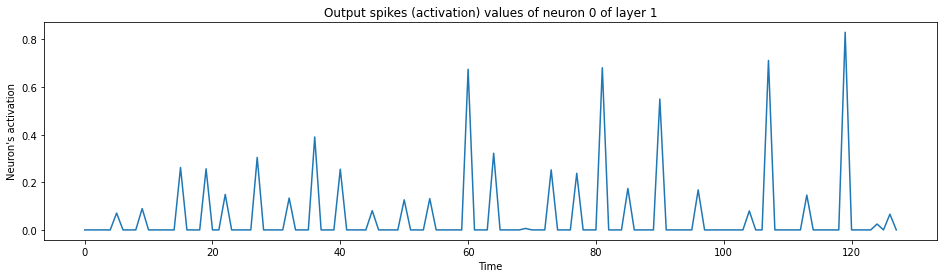

In [0]:
data, target = test_set_loader.__iter__().__next__()


# taking 1 testing example:
x = torch.stack([data[25]])
y = target.data.numpy()[25]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=12)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)

## Deep learning on Mnist and Cifar10

In [0]:
def train(model, device, train_set_loader, optimizer, criterion, scheduler, epoch, logging_interval=20, use_logger=False):
    running_loss = 0.0
    running_acc = 0.0
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        pred = output.max(1, keepdim=True)[1]  
        correct = pred.eq(target.view_as(pred)).float().mean().item()

        running_loss += loss.item()
        running_acc += 100. * correct

        if scheduler:
            scheduler.step(loss)
        
        if batch_idx % int(len(train_set_loader)/logging_interval) == 0:
            pred = output.max(1, keepdim=True)[1]  
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            if use_logger:
                logger.add_scalar(DATA_NAME_LOSS, running_loss/(batch_idx+1), epoch*len(train_set_loader)+batch_idx+1)  # tensorboard logger
                logger.add_scalar(DATA_NAME_ACC, running_acc/(batch_idx+1), epoch*len(train_set_loader)+batch_idx+1)  # tensorboard logger

def train_many_epochs(model, EPOCH, train_set_loader, test_set_loader, use_tensorboard=False): 
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=1000, verbose=False, threshold=1e-4)

    for epoch in range(EPOCH):
        train(model, device, train_set_loader, optimizer, criterion, scheduler, epoch, logging_interval=10, use_logger=use_tensorboard)
        test(model, device, test_set_loader)

def test(model, device, test_set_loader):

    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item() 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")


### Training a ANN - CNN

#### MNIST

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
Q1_DIR = "ANN_CNN_MNIST" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, Q1_DIR))
DATA_NAME_LOSS = "LOSS_ANN" 
DATA_NAME_ACC = "ACC_ANN"

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
ANN_CNN = CNN().to(device)
# train_many_epochs(ANN_CNN,  5, train_set_loader_mnist, test_set_loader_mnist)
train_many_epochs(ANN_CNN,  5, train_set_loader_mnist, test_set_loader_mnist, use_tensorboard=True)

Train Epoch: 0 [0/60000 (0%)] Loss: 2.307074 Accuracy: 6.25%
Train Epoch: 0 [5952/60000 (10%)] Loss: 0.090118 Accuracy: 96.88%
Train Epoch: 0 [11904/60000 (20%)] Loss: 0.060917 Accuracy: 98.44%
Train Epoch: 0 [17856/60000 (30%)] Loss: 0.080514 Accuracy: 96.88%
Train Epoch: 0 [23808/60000 (40%)] Loss: 0.051600 Accuracy: 98.44%
Train Epoch: 0 [29760/60000 (50%)] Loss: 0.031926 Accuracy: 100.00%
Train Epoch: 0 [35712/60000 (59%)] Loss: 0.246358 Accuracy: 96.88%
Train Epoch: 0 [41664/60000 (69%)] Loss: 0.038205 Accuracy: 98.44%
Train Epoch: 0 [47616/60000 (79%)] Loss: 0.026063 Accuracy: 98.44%
Train Epoch: 0 [53568/60000 (89%)] Loss: 0.083557 Accuracy: 93.75%
Train Epoch: 0 [59520/60000 (99%)] Loss: 0.043724 Accuracy: 96.88%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0008, Accuracy: 9832/10000 (98.32%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.008543 Accuracy: 100.00%
Train Epoch: 1 [5952/60000 (10%)] Loss: 0.005380 Accuracy: 100.00%
Train Epoch: 1 [11904/60000 (20%)] Loss: 0.076242 Accuracy: 98.44%
Train Epoch: 1 [17856/60000 (30%)] Loss: 0.005440 Accuracy: 100.00%
Train Epoch: 1 [23808/60000 (40%)] Loss: 0.113850 Accuracy: 98.44%
Train Epoch: 1 [29760/60000 (50%)] Loss: 0.017135 Accuracy: 100.00%
Train Epoch: 1 [35712/60000 (59%)] Loss: 0.096541 Accuracy: 98.44%
Train Epoch: 1 [41664/60000 (69%)] Loss: 0.025173 Accuracy: 100.00%
Train Epoch: 1 [47616/60000 (79%)] Loss: 0.047783 Accuracy: 98.44%
Train Epoch: 1 [53568/60000 (89%)] Loss: 0.085020 Accuracy: 98.44%
Train Epoch: 1 [59520/60000 (99%)] Loss: 0.044673 Accuracy: 98.44%

Test set: Average loss: 0.0006, Accuracy: 9890/10000 (98.90%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.059849 Accuracy: 96.88%
Train Epoch: 2 [5952/60000 (10%)] Loss: 0.001041 Accuracy: 100.00%
Train E

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
Q1_DIR = "ANN_cnn_MNIST" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, Q1_DIR))
DATA_NAME_LOSS = "LOSS_SNN" 
DATA_NAME_ACC = "ACC_SNN"

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
ANN_CNN = CNN().to(device)
# train_many_epochs(ANN_CNN,  5, train_set_loader_mnist, test_set_loader_mnist)
train_many_epochs(ANN_CNN,  5, train_set_loader_mnist, test_set_loader_mnist, use_tensorboard=True)

Train Epoch: 0 [0/60000 (0%)] Loss: 2.312804 Accuracy: 7.81%
Train Epoch: 0 [5952/60000 (10%)] Loss: 0.145673 Accuracy: 95.31%
Train Epoch: 0 [11904/60000 (20%)] Loss: 0.105322 Accuracy: 95.31%
Train Epoch: 0 [17856/60000 (30%)] Loss: 0.112995 Accuracy: 98.44%
Train Epoch: 0 [23808/60000 (40%)] Loss: 0.045292 Accuracy: 98.44%
Train Epoch: 0 [29760/60000 (50%)] Loss: 0.182960 Accuracy: 95.31%
Train Epoch: 0 [35712/60000 (59%)] Loss: 0.070695 Accuracy: 98.44%
Train Epoch: 0 [41664/60000 (69%)] Loss: 0.032801 Accuracy: 98.44%
Train Epoch: 0 [47616/60000 (79%)] Loss: 0.066638 Accuracy: 96.88%
Train Epoch: 0 [53568/60000 (89%)] Loss: 0.009725 Accuracy: 100.00%
Train Epoch: 0 [59520/60000 (99%)] Loss: 0.013548 Accuracy: 98.44%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0006, Accuracy: 9875/10000 (98.75%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.019587 Accuracy: 98.44%
Train Epoch: 1 [5952/60000 (10%)] Loss: 0.091933 Accuracy: 98.44%
Train Epoch: 1 [11904/60000 (20%)] Loss: 0.062318 Accuracy: 98.44%
Train Epoch: 1 [17856/60000 (30%)] Loss: 0.063247 Accuracy: 95.31%
Train Epoch: 1 [23808/60000 (40%)] Loss: 0.133620 Accuracy: 98.44%
Train Epoch: 1 [29760/60000 (50%)] Loss: 0.075635 Accuracy: 98.44%
Train Epoch: 1 [35712/60000 (59%)] Loss: 0.009866 Accuracy: 100.00%
Train Epoch: 1 [41664/60000 (69%)] Loss: 0.017919 Accuracy: 98.44%
Train Epoch: 1 [47616/60000 (79%)] Loss: 0.059456 Accuracy: 98.44%
Train Epoch: 1 [53568/60000 (89%)] Loss: 0.005101 Accuracy: 100.00%
Train Epoch: 1 [59520/60000 (99%)] Loss: 0.017558 Accuracy: 100.00%

Test set: Average loss: 0.0010, Accuracy: 9806/10000 (98.06%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.027154 Accuracy: 98.44%
Train Epoch: 2 [5952/60000 (10%)] Loss: 0.000680 Accuracy: 100.00%
Train Epo

#### Cifar-10

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
Q1_DIR = "ANN_cnn_CIFAR10" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, Q1_DIR))
DATA_NAME_LOSS = "LOSS_SNN" 
DATA_NAME_ACC = "ACC_SNN"

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
ANN_CNN = CNN(HW=32, in_channels=3).to(device)
# train_many_epochs(ANN_CNN, 10, train_set_loader_cifar10, test_set_loader_cifar10)
train_many_epochs(ANN_CNN, 15, train_set_loader_cifar10, test_set_loader_cifar10, use_tensorboard=False)

Train Epoch: 0 [0/50000 (0%)] Loss: 2.342145 Accuracy: 6.25%
Train Epoch: 0 [4992/50000 (10%)] Loss: 1.750608 Accuracy: 34.38%
Train Epoch: 0 [9984/50000 (20%)] Loss: 1.404086 Accuracy: 46.88%
Train Epoch: 0 [14976/50000 (30%)] Loss: 1.446104 Accuracy: 45.31%
Train Epoch: 0 [19968/50000 (40%)] Loss: 1.449945 Accuracy: 40.62%
Train Epoch: 0 [24960/50000 (50%)] Loss: 1.164477 Accuracy: 56.25%
Train Epoch: 0 [29952/50000 (60%)] Loss: 1.343322 Accuracy: 51.56%
Train Epoch: 0 [34944/50000 (70%)] Loss: 1.035431 Accuracy: 60.94%
Train Epoch: 0 [39936/50000 (80%)] Loss: 0.961210 Accuracy: 70.31%
Train Epoch: 0 [44928/50000 (90%)] Loss: 1.018052 Accuracy: 62.50%
Train Epoch: 0 [49920/50000 (100%)] Loss: 0.914613 Accuracy: 65.62%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0176, Accuracy: 6029/10000 (60.29%)

Train Epoch: 1 [0/50000 (0%)] Loss: 1.161344 Accuracy: 60.94%
Train Epoch: 1 [4992/50000 (10%)] Loss: 0.799849 Accuracy: 67.19%
Train Epoch: 1 [9984/50000 (20%)] Loss: 1.094968 Accuracy: 64.06%
Train Epoch: 1 [14976/50000 (30%)] Loss: 0.947119 Accuracy: 65.62%
Train Epoch: 1 [19968/50000 (40%)] Loss: 0.931843 Accuracy: 67.19%
Train Epoch: 1 [24960/50000 (50%)] Loss: 1.007476 Accuracy: 70.31%
Train Epoch: 1 [29952/50000 (60%)] Loss: 1.036967 Accuracy: 59.38%
Train Epoch: 1 [34944/50000 (70%)] Loss: 0.808724 Accuracy: 76.56%
Train Epoch: 1 [39936/50000 (80%)] Loss: 1.071225 Accuracy: 67.19%
Train Epoch: 1 [44928/50000 (90%)] Loss: 0.933926 Accuracy: 67.19%
Train Epoch: 1 [49920/50000 (100%)] Loss: 0.850066 Accuracy: 70.31%

Test set: Average loss: 0.0144, Accuracy: 6780/10000 (67.80%)

Train Epoch: 2 [0/50000 (0%)] Loss: 0.882356 Accuracy: 67.19%
Train Epoch: 2 [4992/50000 (10%)] Loss: 0.674359 Accuracy: 73.44%
Train Epoch: 

### Training a SNN - CNN

#### MNIST

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
Q1_DIR = "SNN_CNN_MNIST" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, Q1_DIR))
DATA_NAME_LOSS = "LOSS_SNN" 
DATA_NAME_ACC = "ACC_SNN"

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
SNN_CNN = SpikingNet_CNN_Resnet(device, n_time_steps=128, ch_in=1, num_class=10, begin_eval=0, use_res=False)
# train_many_epochs(SNN_CNN, 5, train_set_loader_mnist, test_set_loader_mnist)
train_many_epochs(SNN_CNN, 5, train_set_loader_mnist, test_set_loader_mnist, use_tensorboard=True)

Train Epoch: 0 [0/60000 (0%)] Loss: 2.355635 Accuracy: 14.06%
Train Epoch: 0 [5952/60000 (10%)] Loss: 0.050085 Accuracy: 96.88%
Train Epoch: 0 [11904/60000 (20%)] Loss: 0.100924 Accuracy: 98.44%
Train Epoch: 0 [17856/60000 (30%)] Loss: 0.059976 Accuracy: 96.88%
Train Epoch: 0 [23808/60000 (40%)] Loss: 0.032377 Accuracy: 98.44%
Train Epoch: 0 [29760/60000 (50%)] Loss: 0.143050 Accuracy: 93.75%
Train Epoch: 0 [35712/60000 (59%)] Loss: 0.004028 Accuracy: 100.00%
Train Epoch: 0 [41664/60000 (69%)] Loss: 0.082445 Accuracy: 95.31%
Train Epoch: 0 [47616/60000 (79%)] Loss: 0.086947 Accuracy: 98.44%
Train Epoch: 0 [53568/60000 (89%)] Loss: 0.093075 Accuracy: 96.88%
Train Epoch: 0 [59520/60000 (99%)] Loss: 0.089426 Accuracy: 96.88%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0007, Accuracy: 9858/10000 (98.58%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.065642 Accuracy: 98.44%
Train Epoch: 1 [5952/60000 (10%)] Loss: 0.032762 Accuracy: 98.44%
Train Epoch: 1 [11904/60000 (20%)] Loss: 0.022268 Accuracy: 98.44%
Train Epoch: 1 [17856/60000 (30%)] Loss: 0.035139 Accuracy: 98.44%
Train Epoch: 1 [23808/60000 (40%)] Loss: 0.035599 Accuracy: 98.44%
Train Epoch: 1 [29760/60000 (50%)] Loss: 0.058327 Accuracy: 98.44%
Train Epoch: 1 [35712/60000 (59%)] Loss: 0.016041 Accuracy: 100.00%
Train Epoch: 1 [41664/60000 (69%)] Loss: 0.012920 Accuracy: 100.00%
Train Epoch: 1 [47616/60000 (79%)] Loss: 0.051450 Accuracy: 98.44%
Train Epoch: 1 [53568/60000 (89%)] Loss: 0.007024 Accuracy: 100.00%
Train Epoch: 1 [59520/60000 (99%)] Loss: 0.020176 Accuracy: 100.00%

Test set: Average loss: 0.0007, Accuracy: 9887/10000 (98.87%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.143063 Accuracy: 98.44%
Train Epoch: 2 [5952/60000 (10%)] Loss: 0.014664 Accuracy: 100.00%
Train Ep

#### Cifar-10

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
Q1_DIR = "SNN_CNN_CIFAR10" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, Q1_DIR))
DATA_NAME_LOSS = "LOSS_SNN" 
DATA_NAME_ACC = "ACC_SNN"

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
SNN_CNN = SpikingNet_CNN_Resnet(device, n_time_steps=128, begin_eval=0, HW=32, ch_in=3, num_class=10, use_res=False)
# train_many_epochs(SNN_CNN, 10, train_set_loader_cifar10, test_set_loader_cifar10)
train_many_epochs(SNN_CNN, 15, train_set_loader_cifar10, test_set_loader_cifar10, use_tensorboard=True)

Train Epoch: 0 [0/50000 (0%)] Loss: 2.355045 Accuracy: 12.50%
Train Epoch: 0 [4992/50000 (10%)] Loss: 1.860845 Accuracy: 25.00%
Train Epoch: 0 [9984/50000 (20%)] Loss: 1.523907 Accuracy: 43.75%
Train Epoch: 0 [14976/50000 (30%)] Loss: 1.569458 Accuracy: 43.75%
Train Epoch: 0 [19968/50000 (40%)] Loss: 1.385684 Accuracy: 45.31%
Train Epoch: 0 [24960/50000 (50%)] Loss: 1.359517 Accuracy: 51.56%
Train Epoch: 0 [29952/50000 (60%)] Loss: 1.125082 Accuracy: 59.38%
Train Epoch: 0 [34944/50000 (70%)] Loss: 1.275528 Accuracy: 56.25%
Train Epoch: 0 [39936/50000 (80%)] Loss: 0.895611 Accuracy: 75.00%
Train Epoch: 0 [44928/50000 (90%)] Loss: 1.244764 Accuracy: 57.81%
Train Epoch: 0 [49920/50000 (100%)] Loss: 1.087555 Accuracy: 56.25%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0181, Accuracy: 6018/10000 (60.18%)

Train Epoch: 1 [0/50000 (0%)] Loss: 0.981444 Accuracy: 62.50%
Train Epoch: 1 [4992/50000 (10%)] Loss: 1.182918 Accuracy: 67.19%
Train Epoch: 1 [9984/50000 (20%)] Loss: 0.999226 Accuracy: 54.69%
Train Epoch: 1 [14976/50000 (30%)] Loss: 1.156048 Accuracy: 62.50%
Train Epoch: 1 [19968/50000 (40%)] Loss: 0.971699 Accuracy: 59.38%
Train Epoch: 1 [24960/50000 (50%)] Loss: 0.838028 Accuracy: 71.88%
Train Epoch: 1 [29952/50000 (60%)] Loss: 1.161975 Accuracy: 57.81%
Train Epoch: 1 [34944/50000 (70%)] Loss: 0.849818 Accuracy: 70.31%
Train Epoch: 1 [39936/50000 (80%)] Loss: 1.270409 Accuracy: 53.12%
Train Epoch: 1 [44928/50000 (90%)] Loss: 0.809402 Accuracy: 67.19%
Train Epoch: 1 [49920/50000 (100%)] Loss: 0.874057 Accuracy: 62.50%

Test set: Average loss: 0.0155, Accuracy: 6613/10000 (66.13%)

Train Epoch: 2 [0/50000 (0%)] Loss: 0.693594 Accuracy: 78.12%
Train Epoch: 2 [4992/50000 (10%)] Loss: 0.952663 Accuracy: 68.75%
Train Epoch: 

### Training a SNN - Resnet

#### MNIST

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
Q1_DIR = "SNN_Resnet_MNIST" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, Q1_DIR))
DATA_NAME_LOSS = "LOSS_SNN" 
DATA_NAME_ACC = "ACC_SNN"

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
SNN_CNN_Res = SpikingNet_CNN_Resnet(device, n_time_steps=128, begin_eval=0, ch_in=1, num_class=10, use_res=True)
# train_many_epochs(SNN_CNN_Res, 5, train_set_loader_mnist, test_set_loader_mnist)
train_many_epochs(SNN_CNN_Res, 5, train_set_loader_mnist, test_set_loader_mnist, use_tensorboard=True)

Train Epoch: 0 [0/60000 (0%)] Loss: 2.431505 Accuracy: 10.94%
Train Epoch: 0 [5952/60000 (10%)] Loss: 0.533552 Accuracy: 79.69%
Train Epoch: 0 [11904/60000 (20%)] Loss: 0.311884 Accuracy: 92.19%
Train Epoch: 0 [17856/60000 (30%)] Loss: 0.108298 Accuracy: 96.88%
Train Epoch: 0 [23808/60000 (40%)] Loss: 0.214378 Accuracy: 92.19%
Train Epoch: 0 [29760/60000 (50%)] Loss: 0.282094 Accuracy: 95.31%
Train Epoch: 0 [35712/60000 (59%)] Loss: 0.033959 Accuracy: 100.00%
Train Epoch: 0 [41664/60000 (69%)] Loss: 0.141231 Accuracy: 95.31%
Train Epoch: 0 [47616/60000 (79%)] Loss: 0.056613 Accuracy: 98.44%
Train Epoch: 0 [53568/60000 (89%)] Loss: 0.154715 Accuracy: 96.88%
Train Epoch: 0 [59520/60000 (99%)] Loss: 0.006744 Accuracy: 100.00%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0010, Accuracy: 9836/10000 (98.36%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.181452 Accuracy: 93.75%
Train Epoch: 1 [5952/60000 (10%)] Loss: 0.135252 Accuracy: 95.31%
Train Epoch: 1 [11904/60000 (20%)] Loss: 0.206379 Accuracy: 95.31%
Train Epoch: 1 [17856/60000 (30%)] Loss: 0.048066 Accuracy: 98.44%
Train Epoch: 1 [23808/60000 (40%)] Loss: 0.005596 Accuracy: 100.00%
Train Epoch: 1 [29760/60000 (50%)] Loss: 0.012896 Accuracy: 100.00%
Train Epoch: 1 [35712/60000 (59%)] Loss: 0.029150 Accuracy: 98.44%
Train Epoch: 1 [41664/60000 (69%)] Loss: 0.016356 Accuracy: 100.00%
Train Epoch: 1 [47616/60000 (79%)] Loss: 0.021631 Accuracy: 100.00%
Train Epoch: 1 [53568/60000 (89%)] Loss: 0.014804 Accuracy: 100.00%
Train Epoch: 1 [59520/60000 (99%)] Loss: 0.025018 Accuracy: 100.00%

Test set: Average loss: 0.0009, Accuracy: 9819/10000 (98.19%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.013608 Accuracy: 100.00%
Train Epoch: 2 [5952/60000 (10%)] Loss: 0.055876 Accuracy: 96.88%
Train 

#### Cifar-10

In [0]:
SNN_CNN_Res = SpikingNet_CNN_Resnet(device, n_time_steps=128, begin_eval=0, HW=32, ch_in=3, num_class=10, use_res=True)
train_many_epochs(SNN_CNN_Res, 10, train_set_loader_cifar10, test_set_loader_cifar10, use_tensorboard=False)

Train Epoch: 0 [0/50000 (0%)] Loss: 2.572499 Accuracy: 9.38%
Train Epoch: 0 [4992/50000 (10%)] Loss: 2.082961 Accuracy: 10.94%
Train Epoch: 0 [9984/50000 (20%)] Loss: 1.839649 Accuracy: 31.25%
Train Epoch: 0 [14976/50000 (30%)] Loss: 1.794212 Accuracy: 35.94%
Train Epoch: 0 [19968/50000 (40%)] Loss: 1.440765 Accuracy: 45.31%
Train Epoch: 0 [24960/50000 (50%)] Loss: 1.472252 Accuracy: 48.44%
Train Epoch: 0 [29952/50000 (60%)] Loss: 1.362732 Accuracy: 51.56%
Train Epoch: 0 [34944/50000 (70%)] Loss: 1.187546 Accuracy: 57.81%
Train Epoch: 0 [39936/50000 (80%)] Loss: 1.239054 Accuracy: 57.81%
Train Epoch: 0 [44928/50000 (90%)] Loss: 1.295538 Accuracy: 59.38%
Train Epoch: 0 [49920/50000 (100%)] Loss: 1.416207 Accuracy: 54.69%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0185, Accuracy: 5830/10000 (58.30%)

Train Epoch: 1 [0/50000 (0%)] Loss: 1.130082 Accuracy: 65.62%
Train Epoch: 1 [4992/50000 (10%)] Loss: 1.222411 Accuracy: 57.81%
Train Epoch: 1 [9984/50000 (20%)] Loss: 1.268741 Accuracy: 54.69%
Train Epoch: 1 [14976/50000 (30%)] Loss: 0.705906 Accuracy: 76.56%
Train Epoch: 1 [19968/50000 (40%)] Loss: 1.157928 Accuracy: 57.81%
Train Epoch: 1 [24960/50000 (50%)] Loss: 1.039252 Accuracy: 64.06%
Train Epoch: 1 [29952/50000 (60%)] Loss: 1.058826 Accuracy: 67.19%
Train Epoch: 1 [34944/50000 (70%)] Loss: 0.688146 Accuracy: 76.56%
Train Epoch: 1 [39936/50000 (80%)] Loss: 0.977491 Accuracy: 65.62%
Train Epoch: 1 [44928/50000 (90%)] Loss: 0.814800 Accuracy: 65.62%
Train Epoch: 1 [49920/50000 (100%)] Loss: 1.177397 Accuracy: 54.69%

Test set: Average loss: 0.0158, Accuracy: 6515/10000 (65.15%)

Train Epoch: 2 [0/50000 (0%)] Loss: 0.803542 Accuracy: 70.31%
Train Epoch: 2 [4992/50000 (10%)] Loss: 1.007185 Accuracy: 64.06%
Train Epoch: 

# Data Post-processing

## Utility functions definition

In [0]:
from textwrap import wrap
import re
import itertools
import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix


# Credits - https://stackoverflow.com/questions/41617463/tensorflow-confusion-matrix-in-tensorboard
def plot_confusion_matrix(correct_labels, predict_labels, labels, display_labels, title='Confusion matrix', tensor_name = 'MyFigure/image', normalize=False):
  ''' 
  Parameters:
      correct_labels                  : These are your true classification categories.
      predict_labels                  : These are you predicted classification categories
      labels                          : This is a lit of labels which will be used to display the axix labels
      title='Confusion matrix'        : Title for your matrix
      tensor_name = 'MyFigure/image'  : Name for the output summay tensor

  Returns:
      summary: TensorFlow summary 

  Other itema to note:
      - Depending on the number of category and the data , you may have to modify the figzie, font sizes etc. 
      - Currently, some of the ticks dont line up due to rotations.
  '''
  cm = confusion_matrix(correct_labels, predict_labels, labels=labels)
  if normalize:
      cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
      cm = np.nan_to_num(cm, copy=True)
      cm = cm.astype('int')

  np.set_printoptions(precision=2)
  ###fig, ax = matplotlib.figure.Figure()

  fig = matplotlib.pyplot.figure(figsize=(2, 2), dpi=320, facecolor='w', edgecolor='k')
  ax = fig.add_subplot(1, 1, 1)
  im = ax.imshow(cm, cmap='Oranges')

  classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in display_labels]
  classes = ['\n'.join(wrap(l, 40)) for l in classes]

  tick_marks = np.arange(len(classes))

  ax.set_xlabel('Predicted', fontsize=7)
  ax.set_xticks(tick_marks)
  c = ax.set_xticklabels(classes, fontsize=4, rotation=-90,  ha='center')
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  ax.set_ylabel('True Label', fontsize=7)
  ax.set_yticks(tick_marks)
  ax.set_yticklabels(classes, fontsize=4, va ='center')
  ax.yaxis.set_label_position('left')
  ax.yaxis.tick_left()

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")
  fig.set_tight_layout(True)
  matplotlib.pyplot.show()

  return

In [0]:
def predict(model, device, test_set_loader):
    pre_ls = np.array([])
    class_ls = np.array([])
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]

            pre_ls = np.append(pre_ls, pred.cpu().numpy())
            class_ls = np.append(class_ls, target.cpu().numpy())
    # print("")
    # print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    #     test_loss, 
    #     correct, len(test_set_loader.dataset),
    #     100. * correct / len(test_set_loader.dataset)))
    # print("")

    return(pre_ls, class_ls)

###Feed Forward ANN

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


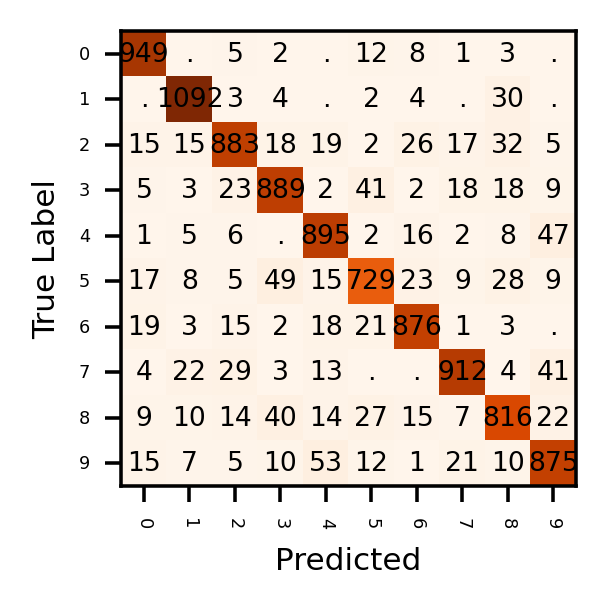

In [0]:
true, predict = pred(non_spiking_model, device, test_set_loader)

true_list = [list(true[i].cpu().numpy()) for i in range(len(true))]
real = []
for i in range(len(true_list)):
  real += true_list[i]

pred_list = [list(predict[i].cpu().numpy()) for i in range(len(predict))]
prediction = []
for i in range(len(pred_list)):
  prediction += pred_list[i]

name_ls = ["0", "1", "2", "3", "4",	"5", "6", "7", "8", "9"]
plot_confusion_matrix(real, prediction, None, name_ls, title='Confusion matrix', tensor_name = 'MyFigure/ffd_snn_image', normalize=False)

###Feed Forward SNN

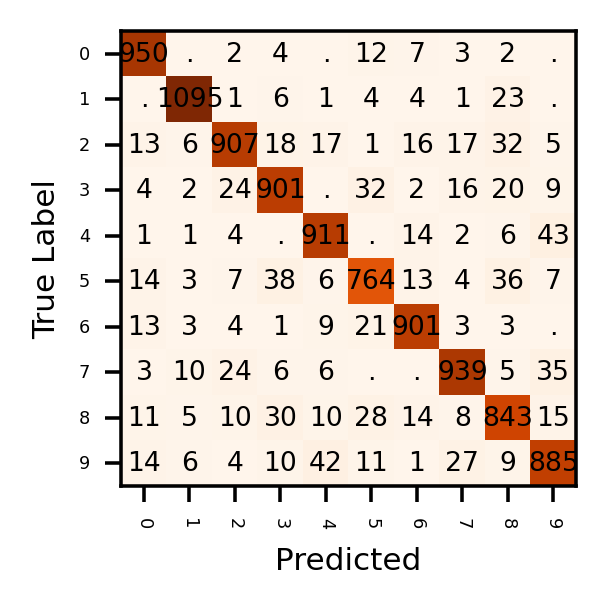

In [0]:
true, predict = pred(feed_forward_spiking_model_attn, device, test_set_loader)

true_list = [list(true[i].cpu().numpy()) for i in range(len(true))]
real = []
for i in range(len(true_list)):
  real += true_list[i]

pred_list = [list(predict[i].cpu().numpy()) for i in range(len(predict))]
prediction = []
for i in range(len(pred_list)):
  prediction += pred_list[i]

name_ls = ["0", "1", "2", "3", "4",	"5", "6", "7", "8", "9"]
plot_confusion_matrix(real, prediction, None, name_ls, title='Confusion matrix', tensor_name = 'MyFigure/ffd_snn_image', normalize=False)

## CNN for Cifar10

In [0]:
pred, target = predict(ANN_CNN, device, test_set_loader_cifar10)

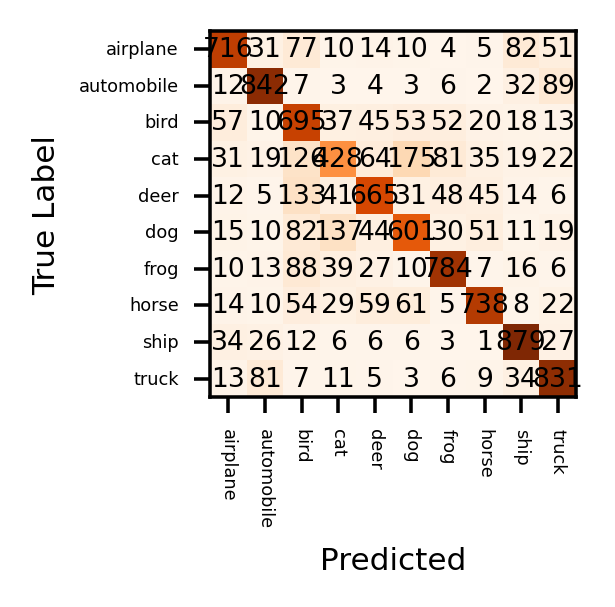

In [0]:
name_ls = ["airplane", "automobile", "bird", "cat", "deer",	"dog", "frog", "horse", "ship", "truck"]
plot_confusion_matrix(target, pred, None, name_ls, title='Confusion matrix', tensor_name = 'MyFigure/image', normalize=False)

## SCNN-Res for Cifar10

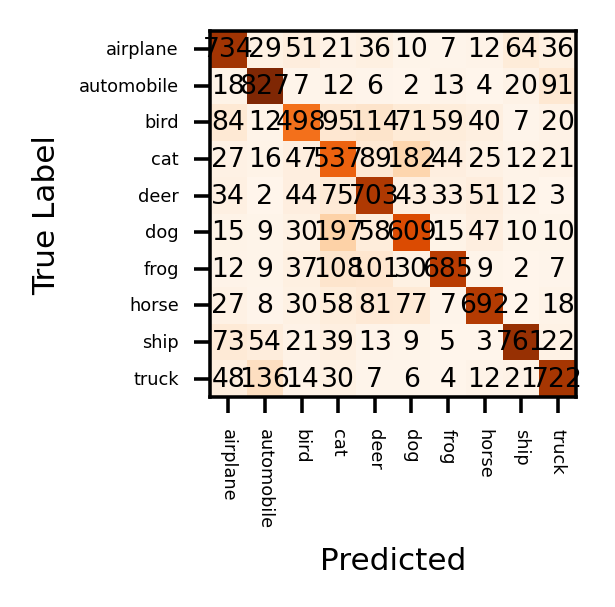

In [0]:
pred, target = predict(SNN_CNN_Res, device, test_set_loader_cifar10)
name_ls = ["airplane", "automobile", "bird", "cat", "deer",	"dog", "frog", "horse", "ship", "truck"]
plot_confusion_matrix(target, pred, None, name_ls, title='Confusion matrix', tensor_name = 'MyFigure/image', normalize=False)